In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import ast
from IPython.display import display
import numpy as np
import seaborn as sns

override_files = (list(Path('.').glob('**/overrides.yaml')))
df = pd.DataFrame()
for override_file in override_files:    
       
    factors = yaml.safe_load(override_file.read_text())
    factors = dict([elm.split('=') for elm in factors if elm[0] != '+'])
    
    factors = pd.DataFrame(factors,index=range(0,int(factors['epochs']))) #Factors df with a duplicate row per epoch
    factors['epoch'] = list(range(1,int(factors.epochs[0]) + 1 )) #Adding epoch number to each row
    
    log_file =  override_file.parent.parent /'TrainModel.log'
    with open(log_file) as f:
        metrics = [log.split("- ")[-1].strip().split(': ') for log in f.readlines() if '__main__' in log]
        metrics = pd.DataFrame({k:ast.literal_eval(v) for k,v in metrics}) #Metric df containing the log metrics
    
    #concat factor and metrics dfs to the final df
    df = pd.concat([df, pd.concat([factors, metrics],axis=1)])
    

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 9
Data columns (total 9 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   modelconf                                    300 non-null    object 
 1   modelconf.layersconf.Random_Flip.mode        300 non-null    object 
 2   modelconf.layersconf.Random_Rotation.factor  300 non-null    object 
 3   epochs                                       300 non-null    object 
 4   epoch                                        300 non-null    int64  
 5   Train Accuracy                               300 non-null    float64
 6   Train Loss                                   300 non-null    float64
 7   Validation Accuracy                          300 non-null    float64
 8   Validation Loss                              300 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 23.4+ KB


In [4]:
df = df.rename(columns={'modelconf.layersconf.Random_Flip.mode':'Random_Flip', 'modelconf.layersconf.Random_Rotation.factor':'Random_Rotation'})
df.epoch = df.epoch.astype('uint8')

In [5]:
desc = df[df.epoch > 6].groupby(['Random_Flip','Random_Rotation']).describe()
val_acc = desc['Validation Accuracy'].reset_index().sort_values('50%', ascending=False)
train_acc = desc['Train Accuracy'].reset_index().sort_values('50%', ascending=False)

In [6]:
val_acc.iloc[0:6,:]

,Random_Flip,Random_Rotation,count,mean,std,min,25%,50%,75%,max
2,horizontal_and_vertical,0.0,20.0,0.596798,0.082098,0.478654,0.534009,0.608538,0.643723,0.755065
0,horizontal,0.0,20.0,0.566462,0.067613,0.534009,0.534009,0.534009,0.534009,0.719971
1,horizontal,0.2,20.0,0.554740,0.081371,0.451881,0.534009,0.534009,0.534009,0.732272
3,horizontal_and_vertical,0.2,20.0,0.511614,0.047328,0.390738,0.534009,0.534009,0.534009,0.534009
4,vertical,0.0,20.0,0.581241,0.062388,0.534009,0.534009,0.534009,0.631693,0.689219
5,vertical,0.2,20.0,0.534009,0.000000,0.534009,0.534009,0.534009,0.534009,0.534009


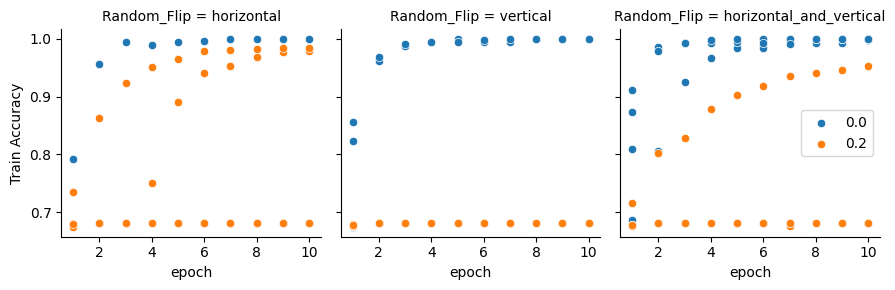

In [7]:
g = sns.FacetGrid(df, col = 'Random_Flip', col_wrap=3, hue='Random_Rotation')
g.map_dataframe(sns.scatterplot, x='epoch', y='Train Accuracy')
plt.tight_layout()
plt.legend()

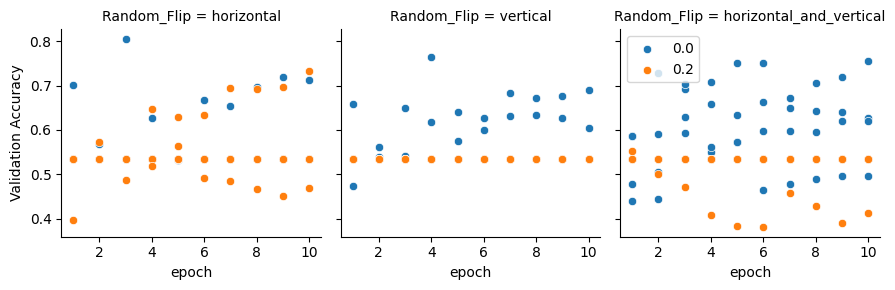

In [8]:
g = sns.FacetGrid(df, col = 'Random_Flip', col_wrap=3, hue='Random_Rotation')
g.map_dataframe(sns.scatterplot, x='epoch', y='Validation Accuracy')
plt.tight_layout()
plt.legend()